<a href="https://colab.research.google.com/github/Latrechesara/e-commerce-mern/blob/main/Famous_Architectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

print(os.path.exists("/content/drive/MyDrive/data"))

True


In [ ]:
os.listdir("/content/drive/MyDrive/data")


['yes', 'no', 'brain_tumor_dataset']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf

data_dir = "/content/drive/MyDrive/data"

img_size = (224, 224)   # resize images
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical"  # or "int" if you prefer numeric labels
)

# Check class names
print(train_ds.class_names)

Found 506 files belonging to 3 classes.
['brain_tumor_dataset', 'no', 'yes']


In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import random
import cv2
import sys

In [ ]:
tumor = []
healthy = []
for f in glob.iglob("/content/drive/MyDrive/data/brain_tumor_dataset/yes/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img,(128,128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    tumor.append(img)

for f in glob.iglob("/content/drive/MyDrive/data/brain_tumor_dataset/no/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img,(128,128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    healthy.append(img)

In [ ]:
healthy = np.array(healthy)
tumor = np.array(tumor)
All = np.concatenate((healthy, tumor))

In [ ]:
healthy.shape


(85, 128, 128, 3)

In [ ]:
tumor.shape


(86, 128, 128, 3)

In [ ]:
np.random.choice(10, 5, replace=False)


array([7, 9, 8, 4, 5])

In [ ]:
def plot_random(healthy, tumor, num=5):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace=False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0], num, replace=False)]

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('healthy')
        plt.imshow(healthy_imgs[i])

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('tumor')
        plt.imshow(tumor_imgs[i])

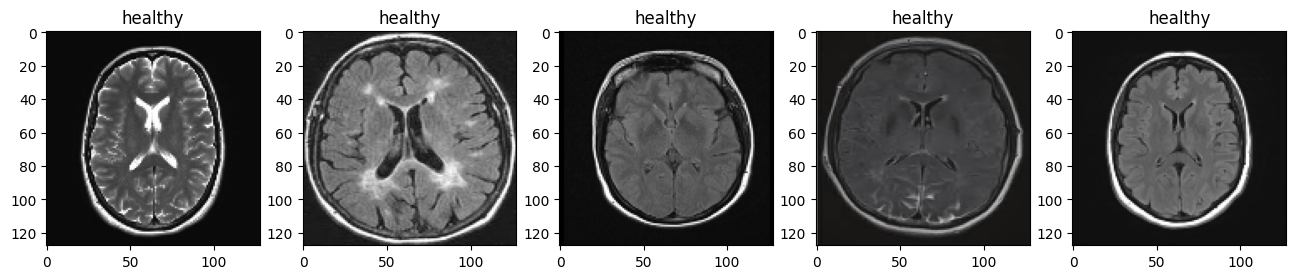

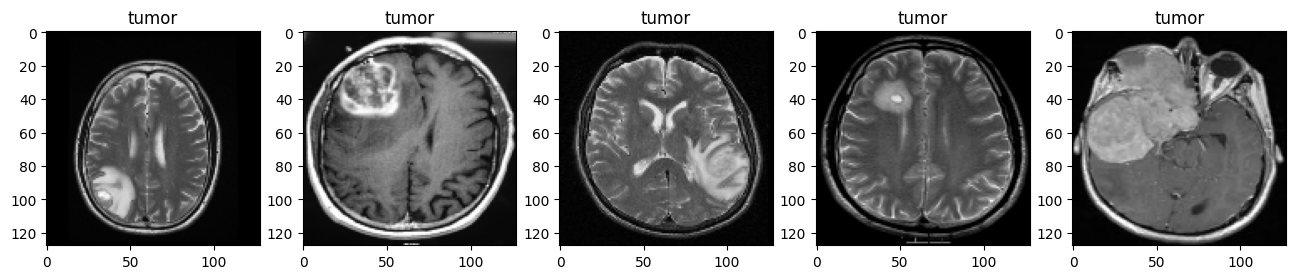

In [ ]:
plot_random(healthy, tumor, num=5)


In [ ]:
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import glob
from torchvision import transforms
from PIL import Image

class MRI(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx].astype(np.uint8)  # back to 0–255
        label = int(self.labels[idx])

        img = Image.fromarray(img)  # numpy → PIL

        if self.transform:
            img = self.transform(img)

        return {'image': img, 'label': label}


# -------------------------
# Preprocessing (read once!)
# -------------------------
tumor, healthy = [], []

for f in glob.iglob("/content/drive/MyDrive/data/brain_tumor_dataset/yes/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img, (128,128))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    tumor.append(img)

for f in glob.iglob("/content/drive/MyDrive/data/brain_tumor_dataset/no/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img, (128,128))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    healthy.append(img)

tumor = np.array(tumor, dtype=np.float32)
healthy = np.array(healthy, dtype=np.float32)

tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)

images = np.concatenate((tumor, healthy), axis=0)
labels = np.concatenate((tumor_label, healthy_label))

# -------------------------
# Train/Val split
# -------------------------
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.20, random_state=42)

# -------------------------
# Transforms
# -------------------------
train_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

# -------------------------
# Final datasets
# -------------------------
train_set = MRI(X_train, y_train, transform=train_transform)
val_set   = MRI(X_val, y_val, transform=val_transform)


In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=32, shuffle=False)


In [ ]:
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn as nn

# Load pretrained ResNet18
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

# Freeze backbone
for param in model.parameters():
    param.requires_grad = False

# Replace classifier
model.fc = nn.Linear(model.fc.in_features, 2)


In [ ]:
from torchvision.models import vgg16, VGG16_Weights
import torch.nn as nn

# Load pretrained VGG16
weights = VGG16_Weights.DEFAULT
model = vgg16(weights=weights)

# Freeze backbone
for param in model.parameters():
    param.requires_grad = False

# Replace classifier (VGG has `classifier` as Sequential)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)


In [ ]:
from torchvision.models import alexnet, AlexNet_Weights
import torch.nn as nn

# Load pretrained AlexNet
weights = AlexNet_Weights.DEFAULT
model = alexnet(weights=weights)

# Freeze backbone
for param in model.parameters():
    param.requires_grad = False

# Replace classifier
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)


In [ ]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
import torch.nn as nn

# Load pretrained MobileNetV2
weights = MobileNet_V2_Weights.DEFAULT
model = mobilenet_v2(weights=weights)

# Freeze backbone
for param in model.parameters():
    param.requires_grad = False

# Replace classifier
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)


In [ ]:
import torch.nn as nn
from torchvision.models import (
    resnet18, ResNet18_Weights,
    vgg16, VGG16_Weights,
    alexnet, AlexNet_Weights,
    mobilenet_v2, MobileNet_V2_Weights
)

def get_pretrained_model(model_name: str, num_classes: int = 2, freeze: bool = True):
    """
    Load a pretrained model and replace the classifier for custom classes.

    Args:
        model_name (str): "resnet", "vgg", "alexnet", "mobilenet"
        num_classes (int): number of output classes
        freeze (bool): if True, freeze feature extractor layers

    Returns:
        model (nn.Module): pretrained model with modified classifier
    """

    model_name = model_name.lower()

    if model_name == "resnet":
        weights = ResNet18_Weights.DEFAULT
        model = resnet18(weights=weights)
        if freeze:
            for param in model.parameters():
                param.requires_grad = False
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    elif model_name == "vgg":
        weights = VGG16_Weights.DEFAULT
        model = vgg16(weights=weights)
        if freeze:
            for param in model.parameters():
                param.requires_grad = False
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

    elif model_name == "alexnet":
        weights = AlexNet_Weights.DEFAULT
        model = alexnet(weights=weights)
        if freeze:
            for param in model.parameters():
                param.requires_grad = False
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

    elif model_name == "mobilenet":
        weights = MobileNet_V2_Weights.DEFAULT
        model = mobilenet_v2(weights=weights)
        if freeze:
            for param in model.parameters():
                param.requires_grad = False
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    else:
        raise ValueError(f"Unknown model name: {model_name}")

    return model


In [ ]:
# Load ResNet18 for 2-class classification
model = get_pretrained_model("resnet", num_classes=2, freeze=True)

# Load VGG16 but allow fine-tuning (no freeze)
model = get_pretrained_model("vgg", num_classes=2, freeze=False)


In [ ]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = get_pretrained_model("resnet", num_classes=2, freeze=True).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        train_loss, correct, total = 0.0, 0, 0

        # Training
        for batch in train_loader:
            images, labels = batch['image'].to(device), batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        acc = 100 * correct / total
        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}, Acc: {acc:.2f}%")

        # Validation
        validate(model, val_loader, criterion)


In [ ]:
def validate(model, val_loader, criterion):
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for batch in val_loader:
            images, labels = batch['image'].to(device), batch['label'].to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = 100 * correct / total
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Acc: {acc:.2f}%")
    model.train()


In [ ]:
# Try ResNet
model = get_pretrained_model("resnet", num_classes=2, freeze=True).to(device)
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5)

# Try VGG
model = get_pretrained_model("vgg", num_classes=2, freeze=True).to(device)
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5)


Epoch 1/5, Loss: 0.8592, Acc: 51.47%
Validation Loss: 0.5646, Acc: 80.00%
Epoch 2/5, Loss: 0.8254, Acc: 52.21%
Validation Loss: 0.6957, Acc: 71.43%
Epoch 3/5, Loss: 0.8107, Acc: 50.74%
Validation Loss: 0.8584, Acc: 51.43%
Epoch 4/5, Loss: 0.9206, Acc: 52.21%
Validation Loss: 0.9468, Acc: 45.71%
Epoch 5/5, Loss: 0.7581, Acc: 50.74%
Validation Loss: 1.0159, Acc: 45.71%
Epoch 1/5, Loss: 0.7806, Acc: 50.74%
Validation Loss: 0.5709, Acc: 77.14%
Epoch 2/5, Loss: 0.8432, Acc: 50.74%
Validation Loss: 0.5709, Acc: 77.14%
Epoch 3/5, Loss: 0.7840, Acc: 51.47%
Validation Loss: 0.5709, Acc: 77.14%
Epoch 4/5, Loss: 0.8339, Acc: 50.74%
Validation Loss: 0.5709, Acc: 77.14%
Epoch 5/5, Loss: 0.7046, Acc: 60.29%
Validation Loss: 0.5709, Acc: 77.14%


In [ ]:
import pandas as pd

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10, model_name="model"):
    history = []  # store metrics here

    for epoch in range(epochs):
        # --- Training ---
        model.train()
        train_loss, correct, total = 0.0, 0, 0
        for batch in train_loader:
            images, labels = batch['image'].to(device), batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        avg_train_loss = train_loss / len(train_loader)

        # --- Validation ---
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for batch in val_loader:
                images, labels = batch['image'].to(device), batch['label'].to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc = 100 * correct / total
        avg_val_loss = val_loss / len(val_loader)

        # Save metrics for this epoch
        history.append({
            "epoch": epoch + 1,
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "train_acc": train_acc,
            "val_acc": val_acc,
            "model": model_name
        })

        print(f"[{model_name}] Epoch {epoch+1}/{epochs} "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}% "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    return pd.DataFrame(history)


In [ ]:
criterion = nn.CrossEntropyLoss()
epochs = 5

# Train ResNet
model = get_pretrained_model("resnet", num_classes=2, freeze=True).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
resnet_history = train_model(model, train_loader, val_loader, criterion, optimizer, epochs, model_name="ResNet18")

# Train VGG
model = get_pretrained_model("vgg", num_classes=2, freeze=True).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
vgg_history = train_model(model, train_loader, val_loader, criterion, optimizer, epochs, model_name="VGG16")


[ResNet18] Epoch 1/5 Train Loss: 0.8310, Train Acc: 44.85% Val Loss: 0.7906, Val Acc: 51.43%
[ResNet18] Epoch 2/5 Train Loss: 0.7501, Train Acc: 50.00% Val Loss: 0.7422, Val Acc: 51.43%
[ResNet18] Epoch 3/5 Train Loss: 0.8596, Train Acc: 42.65% Val Loss: 0.7036, Val Acc: 54.29%
[ResNet18] Epoch 4/5 Train Loss: 0.7691, Train Acc: 44.85% Val Loss: 0.6599, Val Acc: 51.43%
[ResNet18] Epoch 5/5 Train Loss: 0.8103, Train Acc: 46.32% Val Loss: 0.6554, Val Acc: 65.71%
[VGG16] Epoch 1/5 Train Loss: 0.8121, Train Acc: 52.21% Val Loss: 0.6767, Val Acc: 57.14%
[VGG16] Epoch 2/5 Train Loss: 0.8379, Train Acc: 51.47% Val Loss: 0.6421, Val Acc: 68.57%
[VGG16] Epoch 3/5 Train Loss: 0.7625, Train Acc: 49.26% Val Loss: 0.6180, Val Acc: 68.57%
[VGG16] Epoch 4/5 Train Loss: 0.6884, Train Acc: 53.68% Val Loss: 0.5947, Val Acc: 71.43%
[VGG16] Epoch 5/5 Train Loss: 0.6376, Train Acc: 61.76% Val Loss: 0.5730, Val Acc: 77.14%


In [ ]:
all_history = pd.concat([resnet_history, vgg_history], ignore_index=True)


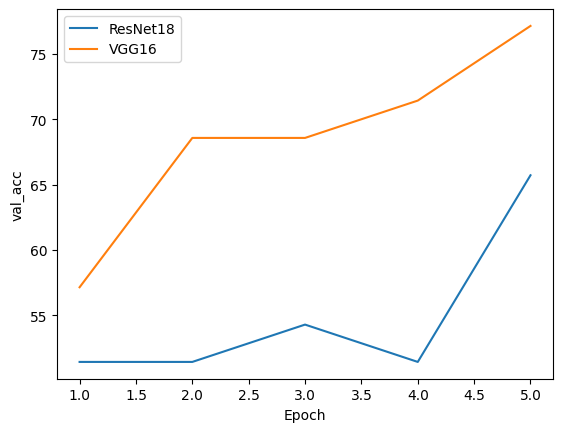

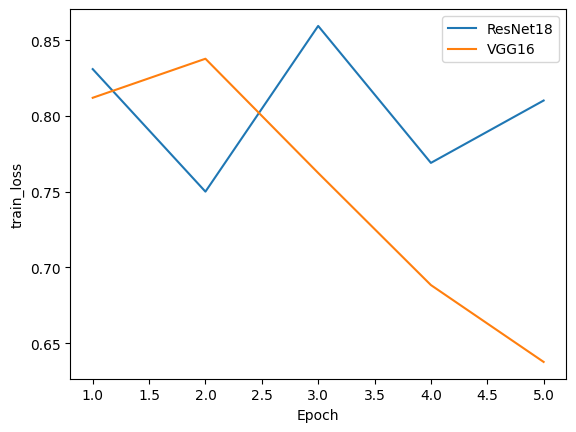

In [ ]:
import matplotlib.pyplot as plt

def plot_history(df, metric="val_acc"):
    for model_name in df["model"].unique():
        subset = df[df["model"] == model_name]
        plt.plot(subset["epoch"], subset[metric], label=model_name)
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.legend()
    plt.show()

plot_history(all_history, "val_acc")
plot_history(all_history, "train_loss")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score
from torchvision import transforms, models
import numpy as np

# --------------------------
# Augmentations
# --------------------------
train_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

# --------------------------
# Data
# --------------------------
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16, shuffle=False)

# --------------------------
# Model (example ResNet18 unfrozen)
# --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = True  # allow fine-tuning

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# --------------------------
# Training loop with F1
# --------------------------
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        train_loss, train_preds, train_labels = 0.0, [], []

        for batch in train_loader:
            imgs, labels = batch['image'].to(device), batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(1).cpu().numpy()
            train_preds.extend(preds)
            train_labels.extend(labels.cpu().numpy())

        train_acc = np.mean(np.array(train_preds) == np.array(train_labels))
        train_f1 = f1_score(train_labels, train_preds, average="macro")

        # ---------------- val ----------------
        model.eval()
        val_loss, val_preds, val_labels = 0.0, [], []
        with torch.no_grad():
            for batch in val_loader:
                imgs, labels = batch['image'].to(device), batch['label'].to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * imgs.size(0)
                preds = outputs.argmax(1).cpu().numpy()
                val_preds.extend(preds)
                val_labels.extend(labels.cpu().numpy())

        val_acc = np.mean(np.array(val_preds) == np.array(val_labels))
        val_f1 = f1_score(val_labels, val_preds, average="macro")

        print(f"[Epoch {epoch+1}/{epochs}] "
              f"Train Loss: {train_loss/len(train_loader.dataset):.4f}, "
              f"Train Acc: {train_acc*100:.2f}%, Train F1: {train_f1:.4f} | "
              f"Val Loss: {val_loss/len(val_loader.dataset):.4f}, "
              f"Val Acc: {val_acc*100:.2f}%, Val F1: {val_f1:.4f}")

    return model

# --------------------------
# Run training
# --------------------------
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20)


[Epoch 1/20] Train Loss: 0.5529, Train Acc: 77.94%, Train F1: 0.7794 | Val Loss: 0.3011, Val Acc: 91.43%, Val F1: 0.9143
[Epoch 2/20] Train Loss: 0.2052, Train Acc: 91.18%, Train F1: 0.9116 | Val Loss: 0.2530, Val Acc: 94.29%, Val F1: 0.9424
[Epoch 3/20] Train Loss: 0.1732, Train Acc: 93.38%, Train F1: 0.9338 | Val Loss: 0.3653, Val Acc: 85.71%, Val F1: 0.8528
[Epoch 4/20] Train Loss: 0.0521, Train Acc: 100.00%, Train F1: 1.0000 | Val Loss: 0.3062, Val Acc: 94.29%, Val F1: 0.9424
[Epoch 5/20] Train Loss: 0.0361, Train Acc: 99.26%, Train F1: 0.9926 | Val Loss: 0.2223, Val Acc: 94.29%, Val F1: 0.9428
[Epoch 6/20] Train Loss: 0.0333, Train Acc: 100.00%, Train F1: 1.0000 | Val Loss: 0.2233, Val Acc: 85.71%, Val F1: 0.8567
[Epoch 7/20] Train Loss: 0.0638, Train Acc: 98.53%, Train F1: 0.9853 | Val Loss: 0.2253, Val Acc: 94.29%, Val F1: 0.9428
[Epoch 8/20] Train Loss: 0.0096, Train Acc: 100.00%, Train F1: 1.0000 | Val Loss: 0.2041, Val Acc: 94.29%, Val F1: 0.9428
[Epoch 9/20] Train Loss: 0.02

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import models
from sklearn.metrics import f1_score
import copy

# -----------------------------
# Build Model (ResNet18 / VGG16 with Dropout)
# -----------------------------
def build_model(model_name="resnet18", num_classes=2):
    if model_name == "resnet18":
        from torchvision.models import resnet18, ResNet18_Weights
        weights = ResNet18_Weights.DEFAULT
        model = resnet18(weights=weights)
        in_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)
        )
    elif model_name == "vgg16":
        from torchvision.models import vgg16, VGG16_Weights
        weights = VGG16_Weights.DEFAULT
        model = vgg16(weights=weights)
        in_features = model.classifier[6].in_features
        model.classifier[6] = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)
        )
    else:
        raise ValueError("Only resnet18 and vgg16 are supported")
    return model

# -----------------------------
# Training Loop with Scheduler + Early Stopping
# -----------------------------
def train_model(model, train_loader, val_loader, device, epochs=20, lr=1e-4, weight_decay=1e-4, patience=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0
    best_loss = float("inf")
    early_stop_counter = 0

    for epoch in range(1, epochs+1):
        print(f"\n[Epoch {epoch}/{epochs}]")
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0
            all_preds, all_labels = [], []

            for batch in dataloader:
                inputs, labels = batch["image"].to(device), batch["label"].to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            epoch_f1 = f1_score(all_labels, all_preds, average="macro")

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, F1: {epoch_f1:.4f}")

            if phase == "val":
                scheduler.step(epoch_loss)
                print(f"🔄 LR adjusted to {optimizer.param_groups[0]['lr']:.6f}")

                if epoch_f1 > best_f1:
                    best_f1 = epoch_f1
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    early_stop_counter = 0
                else:
                    early_stop_counter += 1
                    if early_stop_counter >= patience:
                        print("⏹️ Early stopping triggered!")
                        model.load_state_dict(best_model_wts)
                        return model

    model.load_state_dict(best_model_wts)
    return model


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ResNet18
model_resnet = build_model("resnet18").to(device)
model_resnet = train_model(model_resnet, train_loader, val_loader, device, epochs=20)

# VGG16
model_vgg = build_model("vgg16").to(device)
model_vgg = train_model(model_vgg, train_loader, val_loader, device, epochs=20)



[Epoch 1/20]
Train Loss: 0.6954, Acc: 0.6838, F1: 0.6761
Val Loss: 0.4481, Acc: 0.7714, F1: 0.7667
🔄 LR adjusted to 0.000100

[Epoch 2/20]
Train Loss: 0.4152, Acc: 0.8015, F1: 0.8012
Val Loss: 0.4264, Acc: 0.8286, F1: 0.8214
🔄 LR adjusted to 0.000100

[Epoch 3/20]
Train Loss: 0.2355, Acc: 0.9118, F1: 0.9116
Val Loss: 0.3245, Acc: 0.9143, F1: 0.9132
🔄 LR adjusted to 0.000100

[Epoch 4/20]
Train Loss: 0.1494, Acc: 0.9559, F1: 0.9559
Val Loss: 0.2568, Acc: 0.9429, F1: 0.9424
🔄 LR adjusted to 0.000100

[Epoch 5/20]
Train Loss: 0.1169, Acc: 0.9706, F1: 0.9706
Val Loss: 0.2444, Acc: 0.9429, F1: 0.9424
🔄 LR adjusted to 0.000100

[Epoch 6/20]
Train Loss: 0.0437, Acc: 0.9926, F1: 0.9926
Val Loss: 0.3042, Acc: 0.9429, F1: 0.9424
🔄 LR adjusted to 0.000100

[Epoch 7/20]
Train Loss: 0.0684, Acc: 0.9779, F1: 0.9779
Val Loss: 0.2276, Acc: 0.9429, F1: 0.9424
🔄 LR adjusted to 0.000100

[Epoch 8/20]
Train Loss: 0.0282, Acc: 0.9926, F1: 0.9926
Val Loss: 0.1601, Acc: 0.9429, F1: 0.9428
🔄 LR adjusted to 0

              precision    recall  f1-score   support

     Healthy       1.00      0.94      0.97        17
       Tumor       0.95      1.00      0.97        18

    accuracy                           0.97        35
   macro avg       0.97      0.97      0.97        35
weighted avg       0.97      0.97      0.97        35



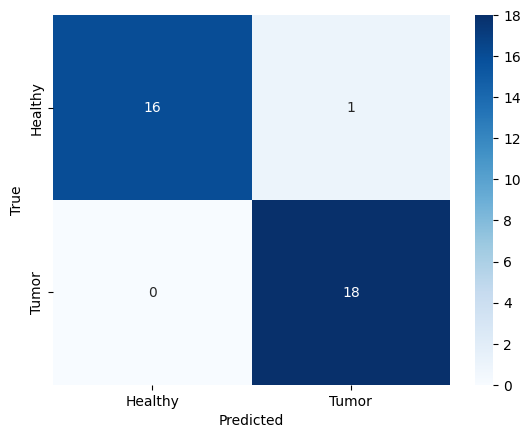

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_true, y_pred = [], []
model_resnet.eval()
with torch.no_grad():
    for batch in val_loader:
        inputs, labels = batch["image"].to(device), batch["label"].to(device)
        outputs = model_resnet(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=["Healthy", "Tumor"]))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy","Tumor"], yticklabels=["Healthy","Tumor"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
def train_model(model, train_loader, val_loader, device, epochs=20, lr=1e-3, weight_decay=1e-4, patience=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)

    best_val_loss = float("inf")
    patience_counter = 0

    history = {
        "train_loss": [], "val_loss": [],
        "train_acc": [], "val_acc": [],
        "train_f1": [], "val_f1": []
    }

    for epoch in range(1, epochs+1):
        # ---- Training ----
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        y_true, y_pred = [], []

        for batch in train_loader:
            inputs, labels = batch["image"].to(device), batch["label"].long().to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

        train_loss = running_loss / total
        train_acc = correct / total
        train_f1 = f1_score(y_true, y_pred)

        # ---- Validation ----
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        y_true, y_pred = [], []

        with torch.no_grad():
            for batch in val_loader:
                inputs, labels = batch["image"].to(device), batch["label"].long().to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        val_loss /= val_total
        val_acc = val_correct / val_total
        val_f1 = f1_score(y_true, y_pred)

        # Save history
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["train_f1"].append(train_f1)
        history["val_f1"].append(val_f1)

        # Print progress
        print(f"[Epoch {epoch}/{epochs}]")
        print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}")
        print(f"Val   Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")

        # Step scheduler
        scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_wts = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("⏹️ Early stopping triggered!")
                break

    # Load best weights
    model.load_state_dict(best_model_wts)
    return model, history


In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, model_name="Model"):
    epochs = range(1, len(history["train_loss"])+1)

    plt.figure(figsize=(14,5))

    # Loss
    plt.subplot(1,3,1)
    plt.plot(epochs, history["train_loss"], label="Train")
    plt.plot(epochs, history["val_loss"], label="Val")
    plt.title(f"{model_name} Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1,3,2)
    plt.plot(epochs, history["train_acc"], label="Train")
    plt.plot(epochs, history["val_acc"], label="Val")
    plt.title(f"{model_name} Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # F1 Score
    plt.subplot(1,3,3)
    plt.plot(epochs, history["train_f1"], label="Train")
    plt.plot(epochs, history["val_f1"], label="Val")
    plt.title(f"{model_name} F1 Score")
    plt.xlabel("Epochs")
    plt.ylabel("F1")
    plt.legend()

    plt.show()


[Epoch 1/20]
Train Loss: 1.0167, Acc: 0.6544, F1: 0.6412
Val   Loss: 1.4516, Acc: 0.5429, F1: 0.6800
[Epoch 2/20]
Train Loss: 0.4626, Acc: 0.8456, F1: 0.8467
Val   Loss: 1.6123, Acc: 0.7143, F1: 0.7826
[Epoch 3/20]
Train Loss: 0.2419, Acc: 0.9044, F1: 0.8992
Val   Loss: 4.3794, Acc: 0.5429, F1: 0.6923
[Epoch 4/20]
Train Loss: 0.1582, Acc: 0.9265, F1: 0.9275
Val   Loss: 0.2235, Acc: 0.9143, F1: 0.9143
[Epoch 5/20]
Train Loss: 0.1660, Acc: 0.9412, F1: 0.9403
Val   Loss: 1.2565, Acc: 0.8571, F1: 0.8718
[Epoch 6/20]
Train Loss: 0.2354, Acc: 0.8897, F1: 0.8855
Val   Loss: 0.8523, Acc: 0.7143, F1: 0.6154
[Epoch 7/20]
Train Loss: 0.1616, Acc: 0.9485, F1: 0.9481
Val   Loss: 0.2983, Acc: 0.9143, F1: 0.9091
[Epoch 8/20]
Train Loss: 0.1495, Acc: 0.9632, F1: 0.9624
Val   Loss: 0.2140, Acc: 0.9429, F1: 0.9474
[Epoch 9/20]
Train Loss: 0.0529, Acc: 0.9926, F1: 0.9927
Val   Loss: 0.2755, Acc: 0.9143, F1: 0.9231
[Epoch 10/20]
Train Loss: 0.0448, Acc: 0.9853, F1: 0.9853
Val   Loss: 0.1107, Acc: 0.9143, 

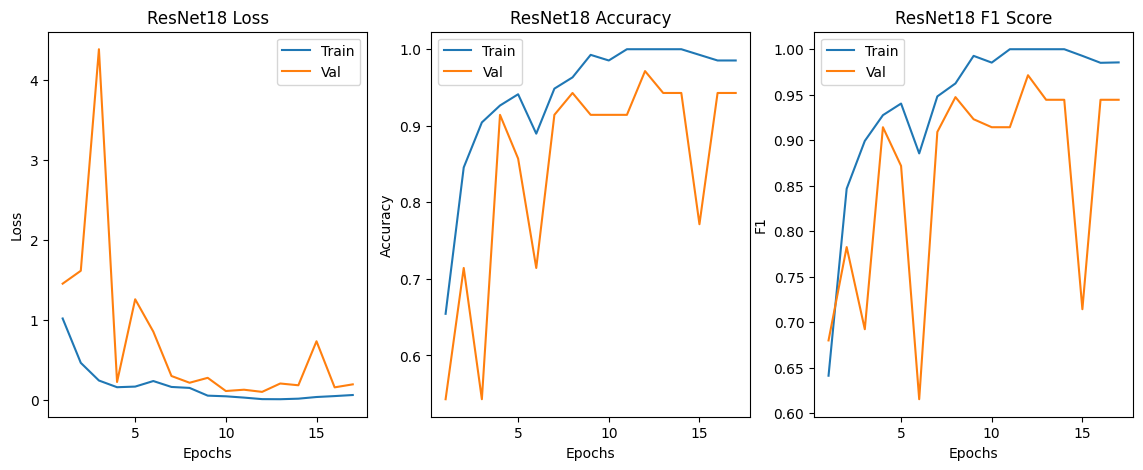

In [ ]:
model_resnet = build_model("resnet18").to(device)
model_resnet, history_resnet = train_model(model_resnet, train_loader, val_loader, device, epochs=20)

plot_history(history_resnet, "ResNet18")
